In [ ]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras
import sys
import cv2


In [3]:
import os
import random
import datetime
import re
import math
import logging
from collections import OrderedDict
import multiprocessing
import numpy as np
import tensorflow as tf
from skimage import io # for grad CAM

import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM
# Root directory of the project
os.chdir('../../')
from mrcnn.config import Config
from mrcnn import model as modellib, utils

class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.

    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when making inferences
        """
        return super(self.__class__, self).call(inputs, training=training)


In [15]:
############################################################
#  Resnet Graph
############################################################

# Code adopted from:
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def resnet_graph(input_image, architecture, stage5=False, train_bn=True):
    """Build a ResNet graph.
        architecture: Can be resnet50 or resnet101
        stage5: Boolean. If False, stage5 of the network is not created
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
    C4 = x
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]


In [ ]:
_, C2, C3, C4, C5 = resnet_graph(input_image, config.BACKBONE,
                                             stage5=True, train_bn=config.TRAIN_BN)

In [5]:
class TshirtConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Tshirt"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + Tshirt

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.98

# TshirtConfig 클래스를 상속받는 InferenceConfig 라는 클래스를 선언한다.
class InferenceConfig(TshirtConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
print(os.getcwd())


C:\Users\chief\FittingroomAnywhere


In [6]:
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='logs')
weights_path = 'C:/Users/chief/FittingroomAnywhere/segmentation/Mask_RCNN/logs/mask_rcnn_tshirt_0028.h5'
model.load_weights(weights_path, by_name=True)

In [18]:

def generate_grad_cam(img_tensor, model, class_index, activation_layer):
    """
    params:
    -------
    img_tensor: resnet50 모델의 이미지 전처리를 통한 image tensor
    model: pretrained resnet50 모델 (include_top=True)
    class_index: 이미지넷 정답 레이블
    activation_layer: 시각화하려는 레이어 이름

    return:
    grad_cam: grad_cam 히트맵
    """
    inp = img_tensor
    A_k = C5
    y_c = 1
    #A_k = model.get_layer(activation_layer).output
    
    ## 이미지 텐서를 입력해서
    ## 해당 액티베이션 레이어의 아웃풋(a_k)과
    ## 소프트맥스 함수 인풋의 a_k에 대한 gradient를 구한다.
    get_output = K.function([inp], [A_k, K.gradients(y_c, A_k)[0], model.output])
    [conv_output, grad_val, model_output] = get_output([img_tensor])

    ## 배치 사이즈가 1이므로 배치 차원을 없앤다.
    conv_output = conv_output[0]
    grad_val = grad_val[0]
    
    ## 구한 gradient를 픽셀 가로세로로 평균내서 a^c_k를 구한다.
    weights = np.mean(grad_val, axis=(0, 1))
    
    ## 추출한 conv_output에 weight를 곱하고 합하여 grad_cam을 얻는다.
    grad_cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam += w * conv_output[:, :, k]
    
    grad_cam = cv2.resize(grad_cam, (224, 224))

    ## ReLU를 씌워 음수를 0으로 만든다.
    grad_cam = np.maximum(grad_cam, 0)

    grad_cam = grad_cam / grad_cam.max()
    from skimage import io, exposure, img_as_uint, img_as_float

    io.use_plugin('freeimage')
    im = exposure.rescale_intensity(grad_cam, out_range='float')
    im = img_as_uint(im)
    io.imsave('grad_cam.png', im)
    return grad_cam

In [19]:
img_tensor = 'C:/Users/chief/Desktop/style.jpg'
class_index = 1
activation_layer = 'res' + str(5) + 'c' + '_branch2c'
generate_grad_cam(img_tensor, model, class_index, activation_layer)

ValueError: Layer zero_padding2d_5 was called with an input that isn't a symbolic tensor. Received type: <class 'str'>. Full input: ['C:/Users/chief/Desktop/style.jpg']. All inputs to the layer should be tensors.

# Binary Mask to Polygon

In [3]:
import numpy as np
from imantics import Polygons, Mask

# This can be any array
array = np.load('C:/Users/chief/Desktop/user_mask.npy')

polygons = Mask(array).polygons()

print(polygons.points)
print(polygons.segmentation)

[array([[214, 190],
       [213, 191],
       [205, 191],
       [204, 192],
       [198, 192],
       [197, 193],
       [193, 193],
       [192, 194],
       [189, 194],
       [188, 195],
       [186, 195],
       [184, 197],
       [183, 197],
       [180, 200],
       [179, 200],
       [178, 201],
       [177, 201],
       [176, 202],
       [174, 202],
       [173, 203],
       [171, 203],
       [170, 204],
       [168, 204],
       [167, 205],
       [165, 205],
       [164, 206],
       [163, 206],
       [158, 211],
       [158, 212],
       [157, 213],
       [157, 214],
       [155, 216],
       [155, 217],
       [153, 219],
       [153, 220],
       [149, 224],
       [149, 225],
       [147, 227],
       [147, 228],
       [146, 229],
       [146, 230],
       [145, 231],
       [145, 233],
       [144, 234],
       [144, 242],
       [143, 243],
       [143, 247],
       [142, 248],
       [142, 250],
       [141, 251],
       [141, 252],
       [140, 253],
       [140

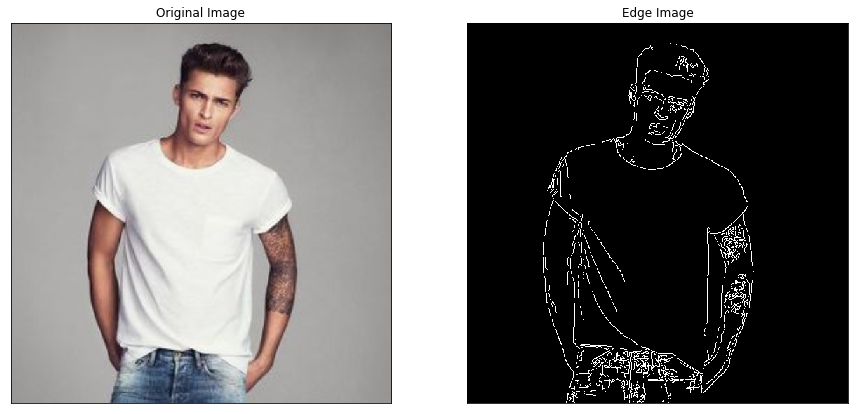

In [33]:
im_path = 'C:/Users/chief/Desktop/white2something/input/user.jpg'

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(im_path)
edges = cv2.Canny(img,50,180)

f, axs = plt.subplots(1,2,figsize=(15,15))
plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [21]:
indices = np.where(edges != [0])
coordinates = zip(indices[0], indices[1])
indices

(array([ 33,  34,  34, ..., 599, 599, 599], dtype=int64),
 array([320, 292, 293, ..., 261, 268, 274], dtype=int64))

In [30]:
def auto_canny(image, sigma=0):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

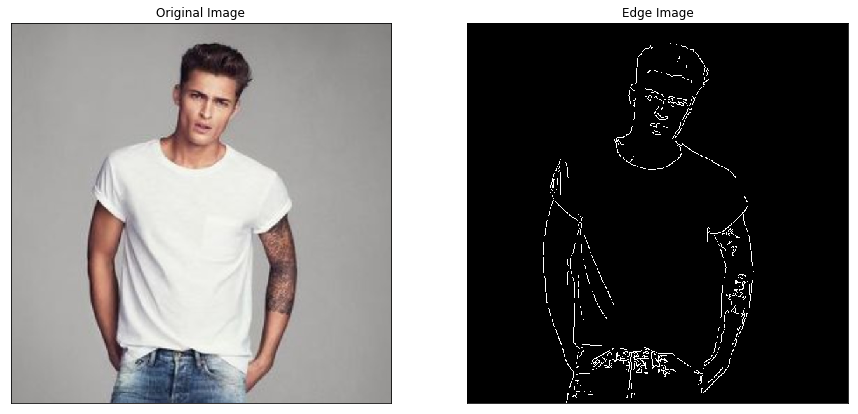

In [31]:
edges = auto_canny(img, sigma=0.33)
f, axs = plt.subplots(1,2,figsize=(15,15))
plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

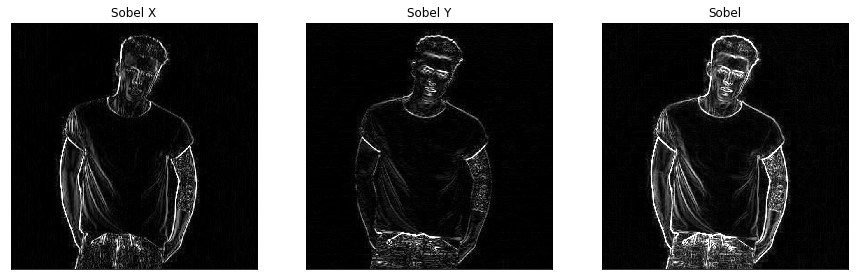

In [34]:
img_color = cv2.imread(im_path, cv2.IMREAD_COLOR)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

img_sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
img_sobel_x = cv2.convertScaleAbs(img_sobel_x)

img_sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
img_sobel_y = cv2.convertScaleAbs(img_sobel_y)


img_sobel = cv2.addWeighted(img_sobel_x, 1, img_sobel_y, 1, 0);

f, axs = plt.subplots(1,3,figsize=(15,15))
plt.subplot(131),plt.imshow(cv2.cvtColor(img_sobel_x, cv2.COLOR_BGR2RGB))
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(cv2.cvtColor(img_sobel_y, cv2.COLOR_BGR2RGB))
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cv2.cvtColor(img_sobel, cv2.COLOR_BGR2RGB))
plt.title('Sobel'), plt.xticks([]), plt.yticks([])

plt.show()